In [2]:
import torch
from dftorch.BondIntegral import read_skf_table, channels_to_matrix, \
    LoadBondIntegralParameters, bond_integral_vectorized, bond_integral_with_grad_vectorized, cubic_spline_coeffs, spline_eval_all
import matplotlib.pyplot as plt
from dftorch.Tools import ordered_pairs_from_TYPE
import sys
### path to PYSEQM ###
sys.path.insert(1, "/home/maxim/Projects/git2/PYSEQM_dev/")

from seqm.seqm_functions.read_xyz import read_xyz

from dftorch.Constants import Constants

import os

from dftorch.nearestneighborlist import vectorized_nearestneighborlist
from dftorch.H0andS import H0_and_S_vectorized

torch.set_default_dtype(torch.float64)



In [138]:
device = 'cpu'
species, coordinates = read_xyz(['COORD.xyz'], sort=False) #Input coordinate file
LBox = torch.tensor([8,6,6], device=device)

# species, coordinates = read_xyz(['C840.xyz'], sort=False) #Input coordinate file
# LBox = torch.tensor([36,36,36], device=device)

# species, coordinates = read_xyz(['solvated_1600.xyz'], sort=False) #Input coordinate file
# LBox = torch.tensor([35,35,35], device=device)

# species, coordinates = read_xyz(['gs_solvated_4k.xyz'], sort=False) #Input coordinate file
# LBox = torch.tensor([100,100,100], device=device)


const = Constants().to(device)

TYPE = torch.tensor(species[0], dtype=torch.int64, device=device)
RX = torch.tensor(coordinates[0,:,0], device=device).to(torch.get_default_dtype())
RY = torch.tensor(coordinates[0,:,1], device=device).to(torch.get_default_dtype())
RZ = torch.tensor(coordinates[0,:,2], device=device).to(torch.get_default_dtype())
Nocc = int(const.tore[TYPE].sum()/2)

Nats = len(RX)

# Get Hamiltonian, Overlap, atomic DM = D0 (vector only), etc, but first the neighborlist
#nrnnlist,nndist,nnRx,nnRy,nnRz,nnType,nnStruct,nrnnStruct  = vectorized_nearestneighborlist(RX,RY,RZ,LBox,4.0,Nats);

nrnnlist_no_self, nndist_no_self, nnRx_no_self, nnRy_no_self, nnRz_no_self, nnType_no_self, nnStruct_no_self, nrnnStruct_no_self  = \
        vectorized_nearestneighborlist(RX, RY, RZ, LBox, 4.0, Nats, upper_tri_only=True, remove_self_neigh=False);

H0, dH0, S, dS, D0, H_INDEX_START, H_INDEX_END, Element_Type, Mnuc,Znuc, Hubbard_U, neighbor_I, neighbor_J = H0_and_S_vectorized(TYPE,RX,RY,RZ,LBox,Nats,
                                                                        nrnnlist_no_self,nnRx_no_self,nnRy_no_self,nnRz_no_self,nnType_no_self, const)

Rab_X = nnRx_no_self - RX.unsqueeze(-1)
Rab_Y = nnRy_no_self - RY.unsqueeze(-1)
Rab_Z = nnRz_no_self - RZ.unsqueeze(-1)

Rab_X = Rab_X - LBox[0] * torch.round(Rab_X / LBox[0])
Rab_Y = Rab_Y - LBox[1] * torch.round(Rab_Y / LBox[1])
Rab_Z = Rab_Z - LBox[2] * torch.round(Rab_Z / LBox[2])

dR = torch.norm(torch.stack((Rab_X, Rab_Y, Rab_Z), dim=-1), dim=-1)
nn_mask = nnType_no_self!=-1 # mask to exclude zero padding from the neigh list
dR_mskd = dR[nn_mask]



H0_and_S
  Load H integral params
  Do H diagonal
  Do H off-diag
  Do H Slater-Koster
  Load S integral params
  Do S Slater-Koster
  t 0.0 s



In [139]:
pairs_tensor, pairs_list, label_list = ordered_pairs_from_TYPE(TYPE, const)
pairs_tensor, pairs_list, label_list

# Allocate padded tensors
n_pairs = len(label_list)
R_tensor = torch.zeros((n_pairs, 499), device=device)
coeffs_tensor = torch.zeros((n_pairs, 498, 20, 4), device=device)

pair_type_dict = {}

for i in range(len(label_list)):
    print(i, label_list[i])
    pair_type_dict[label_list[i]] = i
    R, channels = read_skf_table("sk_orig/mio-1-1/mio-1-1/{}.skf".format(label_list[i]))
    channels_matrix = channels_to_matrix(channels)
    coeffs = cubic_spline_coeffs(R, channels_matrix)

    R_tensor[i] = R
    coeffs_tensor[i] = coeffs

0 H-H
1 H-C
2 C-H
3 C-C


In [140]:
IJ_pair_type = torch.zeros((len(neighbor_I)), dtype=torch.int64, device=device)
JI_pair_type = torch.zeros((len(neighbor_I)), dtype=torch.int64, device=device)

for i in range(len(neighbor_I)):
    IJ_pair_type[i] = pair_type_dict[const.label[TYPE[neighbor_I[i]]] + '-' + const.label[TYPE[neighbor_J[i]]]]
    JI_pair_type[i] = pair_type_dict[const.label[TYPE[neighbor_J[i]]] + '-' + const.label[TYPE[neighbor_I[i]]]]

In [161]:
idx = torch.searchsorted(R_tensor[0], dR_mskd, right=True) - 1
idx = torch.clamp(idx, 0, len(R_tensor[0]))
dx = (dR_mskd - R_tensor[0][idx])
coeffs_selected = coeffs_tensor[IJ_pair_type, idx, 8+10]  # 
y  = coeffs_selected[:,0] + coeffs_selected[:,1]*dx + coeffs_selected[:,2]*dx**2 + coeffs_selected[:,3]*dx**3
dy  = coeffs_selected[:,1] + 2*coeffs_selected[:,2]*dx + 3*coeffs_selected[:,3]*dx**2

coeffs_selected2 = coeffs_tensor[JI_pair_type, idx, 8+10]  # 
y2  = coeffs_selected2[:,0] + coeffs_selected2[:,1]*dx + coeffs_selected2[:,2]*dx**2 + coeffs_selected2[:,3]*dx**3
dy2  = coeffs_selected2[:,1] + 2*coeffs_selected2[:,2]*dx + 3*coeffs_selected2[:,3]*dx**2



In [162]:
f = LoadBondIntegralParameters(neighbor_I, neighbor_J, TYPE, '../src/dftorch/params/S_fsp_sigma.csv').to(torch.float64)
poly = bond_integral_vectorized(dR_mskd, f)
dpoly = bond_integral_with_grad_vectorized(dR_mskd, f)

f2 = LoadBondIntegralParameters(neighbor_J, neighbor_I, TYPE, '../src/dftorch/params/S_fsp_sigma.csv').to(torch.float64)
poly2 = bond_integral_vectorized(dR_mskd, f2)
dpoly2 = bond_integral_with_grad_vectorized(dR_mskd, f2)



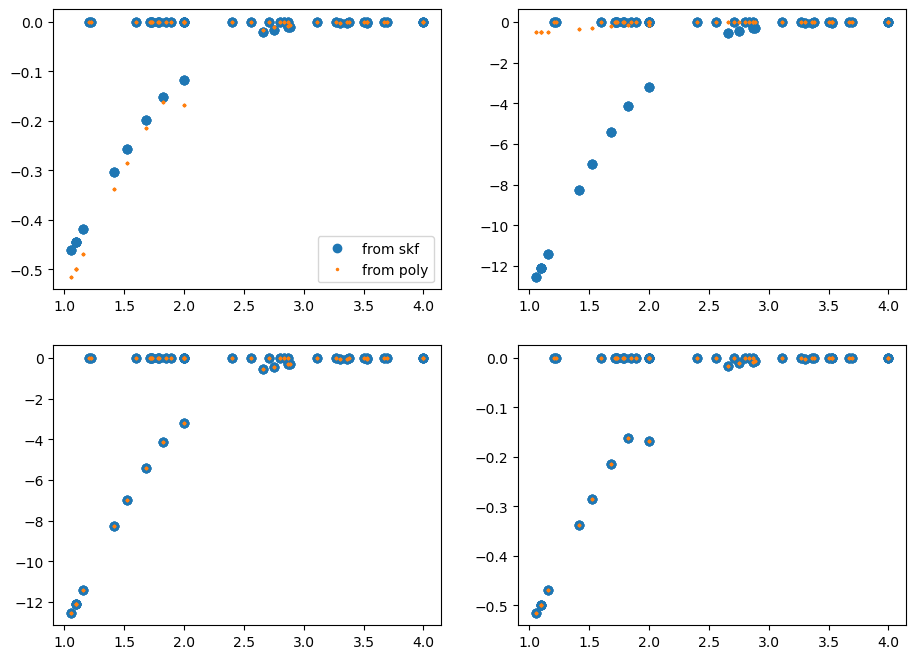

In [166]:
fig, axes = plt.subplots(2, 2, figsize=(11, 8))
axes[0, 0].plot(dR_mskd.cpu(), y.cpu()/27.211399, 'o', label='from skf')
axes[0, 0].plot(dR_mskd.cpu(), poly.cpu(), '.', ms=3, label='from poly')

axes[0, 1].plot(dR_mskd.cpu(), y2.cpu(), 'o', label='from skf2')
axes[0, 1].plot(dR_mskd.cpu(), poly2.cpu(), '.', ms=3, label='from poly2')

axes[1, 0].plot(dR_mskd.cpu(), y.cpu(), 'o', label='from skf')
axes[1, 0].plot(dR_mskd.cpu(), y2.cpu(), '.', ms=3, label='from poly2')

axes[1, 1].plot(dR_mskd.cpu(), poly.cpu(), 'o', label='from skf2')
axes[1, 1].plot(dR_mskd.cpu(), poly2.cpu(), '.', ms=3, label='from poly')

axes[0, 0].legend()

In [150]:
torch.max(abs(y- poly))

tensor(0.0827)

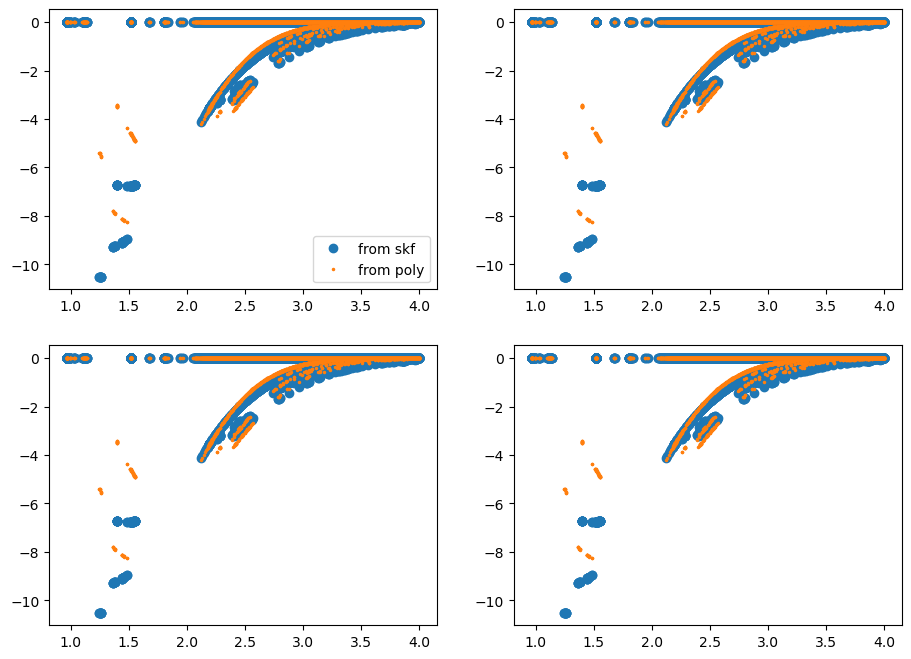

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(11, 8))
axes[0, 0].plot(dR_mskd.cpu(), dy.cpu(), 'o', label='from skf')
axes[0, 0].plot(dR_mskd.cpu(), dpoly.cpu(), '.', ms=3, label='from poly')

axes[0, 1].plot(dR_mskd.cpu(), dy2.cpu(), 'o', label='from skf2')
axes[0, 1].plot(dR_mskd.cpu(), dpoly2.cpu(), '.', ms=3, label='from poly2')

axes[1, 0].plot(dR_mskd.cpu(), dy.cpu(), 'o', label='from skf')
axes[1, 0].plot(dR_mskd.cpu(), dpoly2.cpu(), '.', ms=3, label='from poly2')

axes[1, 1].plot(dR_mskd.cpu(), dy2.cpu(), 'o', label='from skf2')
axes[1, 1].plot(dR_mskd.cpu(), dpoly.cpu(), '.', ms=3, label='from poly')

axes[0, 0].legend()

In [ ]:
coeffs_selected = coeffs_tensor[IJ_pair_type, idx, 9]
HSSS_all  = coeffs_selected[:,0] + coeffs_selected[:,1]*dx + coeffs_selected[:,2]*dx**2 + coeffs_selected[:,3]*dx**3


In [27]:
coeffs_ss

tensor([[ -0.0250,   0.0954,  -0.1778,   0.2112],
        [ -0.6367,   2.0392,  -2.9802,   2.5291],
        [ -0.1078,   0.3910,  -0.6727,   0.6999],
        ...,
        [-13.5190,  22.1139, -11.8656,  -1.7190],
        [-13.5190,  22.1139, -11.8656,  -1.7190],
        [ -3.1135,   4.8836,  -2.8007,   0.3248]])

In [23]:
coeffs_tensor.shape

torch.Size([16, 498, 20, 4])

In [21]:
dR_mskd[0], R_tensor[0,300], R_tensor[0,301]

(tensor(3.1862), tensor(3.1856), tensor(3.1962))

In [59]:
coeffs_tensor[IJ_pair_type,:,0:20,:]

tensor([[[[  2.7211e+01,  -1.6526e-07,   0.0000e+00,   1.4754e-03],
          [  2.7211e+01,  -1.6526e-07,   0.0000e+00,   1.4754e-03],
          [  2.7211e+01,  -1.6526e-07,   0.0000e+00,   1.4754e-03],
          ...,
          [  2.7211e+01,  -1.6526e-07,   0.0000e+00,   1.4754e-03],
          [  2.7211e+01,  -1.9811e-07,   0.0000e+00,   1.7686e-03],
          [  2.7211e+01,  -1.8056e-08,   0.0000e+00,   1.6119e-04]],

         [[  2.7211e+01,   3.3052e-07,   4.6844e-05,  -7.3769e-03],
          [  2.7211e+01,   3.3052e-07,   4.6844e-05,  -7.3769e-03],
          [  2.7211e+01,   3.3052e-07,   4.6844e-05,  -7.3769e-03],
          ...,
          [  2.7211e+01,   3.3052e-07,   4.6844e-05,  -7.3769e-03],
          [  2.7211e+01,   3.9622e-07,   5.6156e-05,  -8.8432e-03],
          [  2.7211e+01,   3.6111e-08,   5.1180e-06,  -8.0597e-04]],

         [[  2.7211e+01,  -1.1568e-06,  -1.8738e-04,   2.8032e-02],
          [  2.7211e+01,  -1.1568e-06,  -1.8738e-04,   2.8032e-02],
          [  2

In [49]:
coeffs_tensor.shape

torch.Size([16, 498, 20, 4])

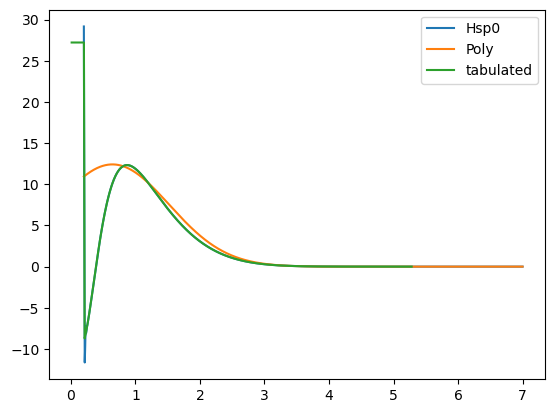

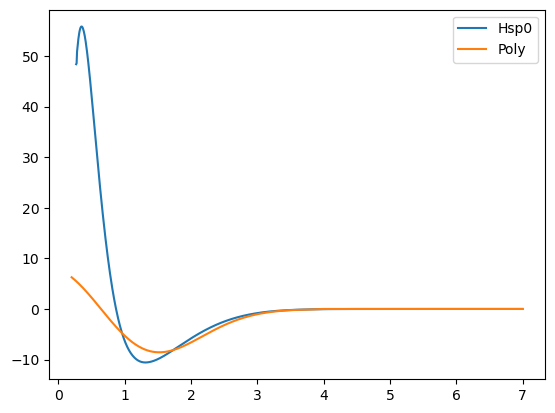

In [36]:
C_C_fsp0 = LoadBondIntegralParameters(torch.tensor([0]), torch.tensor([1]), torch.tensor([6,6]), '../src/dftorch/params/fsp_sigma.csv').to(torch.float64)
poly_C_C_fsp0 = bond_integral_vectorized(x, C_C_fsp0.repeat(len(x),1))
poly_C_C_fsp0_dx = bond_integral_with_grad_vectorized(x, C_C_fsp0.repeat(len(x),1))


for i, key in enumerate(channels_C_C.keys()):
    if key == 'Hsp0':
        plt.plot(x, y[:,i], label=key)
        plt.plot(x, poly_C_C_fsp0, label='Poly')
        plt.plot(R, channels_C_C[key], label='tabulated')
        plt.legend()
        plt.show()

        plt.plot(x[10:], dy[10:,i], label=key)
        plt.plot(x, poly_C_C_fsp0_dx, label='Poly')
        plt.legend()
        plt.show()


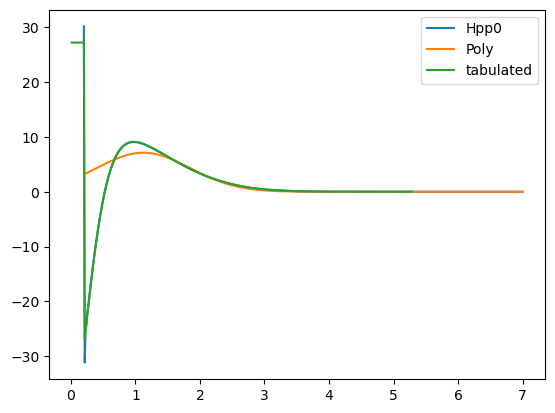

In [ ]:
C_C_fpp0 = LoadBondIntegralParameters(torch.tensor([0]), torch.tensor([1]), torch.tensor([6,6]), '../src/dftorch/params/fpp_sigma.csv').to(torch.float64)
poly_C_C_fpp0 = bond_integral_vectorized(x, C_C_fpp0.repeat(len(x),1))

for i, key in enumerate(channels_C_C.keys()):
    if key == 'Hpp0':
        plt.plot(x, y[:,i], label=key)
        plt.plot(x, poly_C_C_fpp0, label='Poly')
        plt.plot(R, channels_C_C[key], label='tabulated')
        plt.legend()
        plt.show()


In [12]:
fsp_sigma = LoadBondIntegralParameters(torch.tensor([0]), torch.tensor([1]), torch.tensor([1,8]), '../src/dftorch/params/fsp_sigma.csv').to(torch.float64)
fps_sigma = LoadBondIntegralParameters(torch.tensor([0]), torch.tensor([1]), torch.tensor([1,8]), '../src/dftorch/params/fps_sigma.csv').to(torch.float64)

fsp_sigma, fps_sigma


(tensor([[ 9.5187e+00, -1.3332e+00, -3.9371e-01,  0.0000e+00,  0.0000e+00,
           1.0000e+00,  3.5000e+00,  4.0000e+00,  3.0465e-03, -1.0059e-02,
           1.5407e-02, -9.4746e-02,  2.7227e-01, -2.2535e-01]],
        dtype=torch.float64),
 tensor([[ 9.5187e+00, -1.3332e+00, -3.9371e-01,  0.0000e+00,  0.0000e+00,
           1.0000e+00,  3.5000e+00,  4.0000e+00,  3.0465e-03, -1.0059e-02,
           1.5407e-02, -9.4746e-02,  2.7227e-01, -2.2535e-01]],
        dtype=torch.float64))

In [13]:
int1 = LoadBondIntegralParameters(torch.tensor([0]), torch.tensor([1]), torch.tensor([6,8]), '../src/dftorch/params/fsp_sigma.csv').to(torch.float64)
int2 = LoadBondIntegralParameters(torch.tensor([0]), torch.tensor([1]), torch.tensor([8,6]), '../src/dftorch/params/fsp_sigma.csv').to(torch.float64)

int1 - int2


tensor([[-3.4761e+00, -1.7809e-02,  6.6157e-02,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  4.1522e-03, -5.9623e-03,
          2.5125e-03, -2.0415e-01,  6.4509e-01, -5.3113e-01]],
       dtype=torch.float64)

In [ ]:
R_Ni_C, channels_Ni_C = read_skf_table("sk_orig/trans3d-0-1/Ni-C.skf",  "Ni", "C")
R_C_Ni, channels_C_Ni = read_skf_table("sk_orig/trans3d-0-1/C-Ni.skf",  "C", "Ni")

channels_Ni_C_matrix = channels_to_matrix(channels_Ni_C)
channels_C_Ni_matrix = channels_to_matrix(channels_C_Ni)

coeffs_Ni_C = cubic_spline_coeffs(R_Ni_C, channels_Ni_C_matrix)
coeffs_C_Ni = cubic_spline_coeffs(R_C_Ni, channels_C_Ni_matrix)

x = torch.linspace(0.4,7,1000, dtype=torch.float64)
y, dy = spline_eval_all(R_Ni_C, coeffs_Ni_C, x)

In [11]:
coeffs_Ni_C.shape, coeffs_C_Ni.shape

(torch.Size([518, 20, 4]), torch.Size([518, 20, 4]))

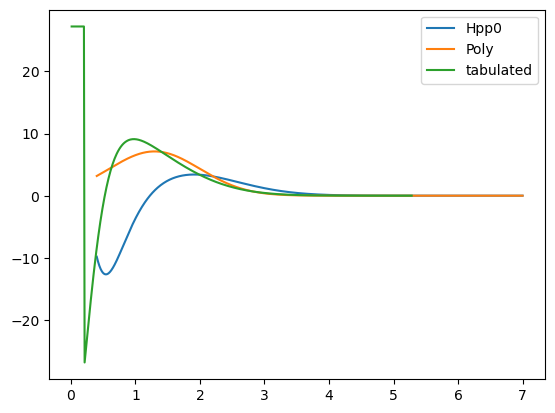

In [16]:
for i, key in enumerate(channels_Ni_C.keys()):
    if key == 'Hpp0':
        plt.plot(x, y[:,i], label=key)
        plt.plot(x, poly_C_C_fpp0, label='Poly')
        plt.plot(R, channels_C_C[key], label='tabulated')
        plt.legend()

        plt.show()